<a href="https://colab.research.google.com/github/Zaripov2004/Test/blob/main/MIT_Arrhythmia_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Yurak-qon tomir kasalliklari MIT-BIH Arrhythmia ma'lumotlarini qayta ishlash

Ushbu bo‘limda MIT-BIH Arrhythmia ma’lumotlar bazasidan foydalanib EKG signallarini yuklash, oldindan qayta ishlash (filtrlash), R-piklarni aniqlash (Pan-Tompkins uslubida yondashuv), xususiyat (feature) ajratish va mashina o‘rganish/chuqur o‘rganish asosida tasniflash bosqichlari ko‘rib chiqiladi. Kodlar praktika uchun to‘liq ishlaydi (paketlar: wfdb, numpy, scipy, matplotlib, sklearn, tensorflow/keras).


#1. Muhit va kutubxonalarni o‘rnatish

Tavsiya etilgan Python paketlarini o‘rnatish:

In [ ]:
!pip install wfdb
#numpy, scipy, matplotlib, pandas, scikit-learn, tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 39.6 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.2 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.


In [ ]:
!pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 34.8 MB/s eta 0:00:00


#2. Ma’lumotlarni yuklash (MIT-BIH)

PhysioNet/MIT-BIH ma’lumotlari bilan ishlash uchun wfdb kutubxonasidan foydalanamiz.

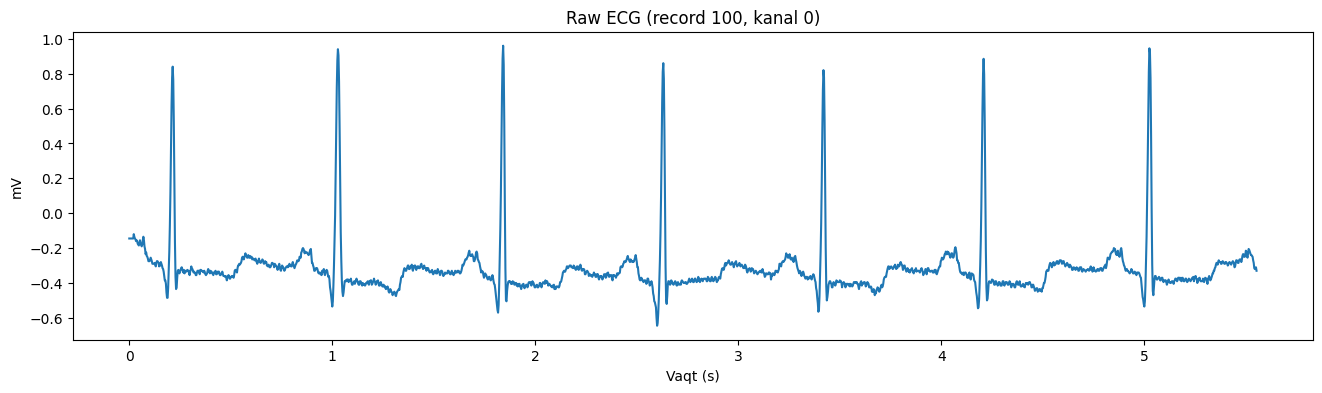

In [ ]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt

# Misol: '100' yozuvini yuklash (pn_dir='mitdb' -> PhysioNet mitdb kutubxonasi)
record = wfdb.rdrecord('100', pn_dir='mitdb')  # internetdan yuklaydi
signal = record.p_signal[:,0]  # birinchi kanal (lead)
fs = record.fs  # namunaviy chastota, ko'pincha 360
t = np.arange(len(5*signal)) / fs

plt.figure(figsize=(16, 4))
plt.plot(t[:2000], signal[:2000])
plt.title('Raw ECG (record 100, kanal 0)')
plt.xlabel('Vaqt (s)')
plt.ylabel('mV')
plt.show()


#3. Signalni oldindan qayta ishlash (preprocessing)
##3.1 Band-pass filtr — 0.5–40 Hz (ECG uchun tavsiya)

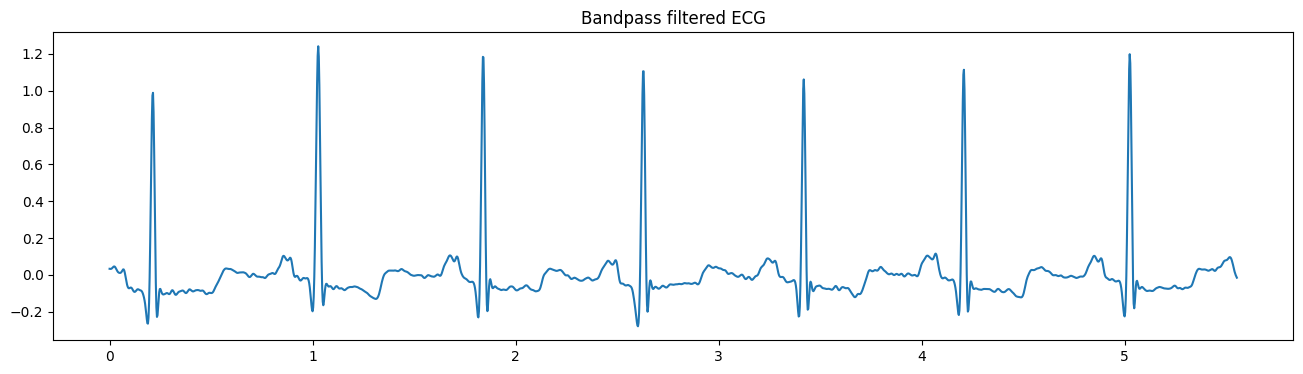

In [ ]:
from scipy.signal import butter, filtfilt

def bandpass_filter(x, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, x)

filtered = bandpass_filter(signal, 0.5, 40, fs)
plt.figure(figsize=(16, 4))
plt.plot(t[:2000], filtered[:2000])
plt.title('Bandpass filtered ECG')
plt.show()



##3.2 Notch filter (50/60 Hz) — kerak bo‘lsa

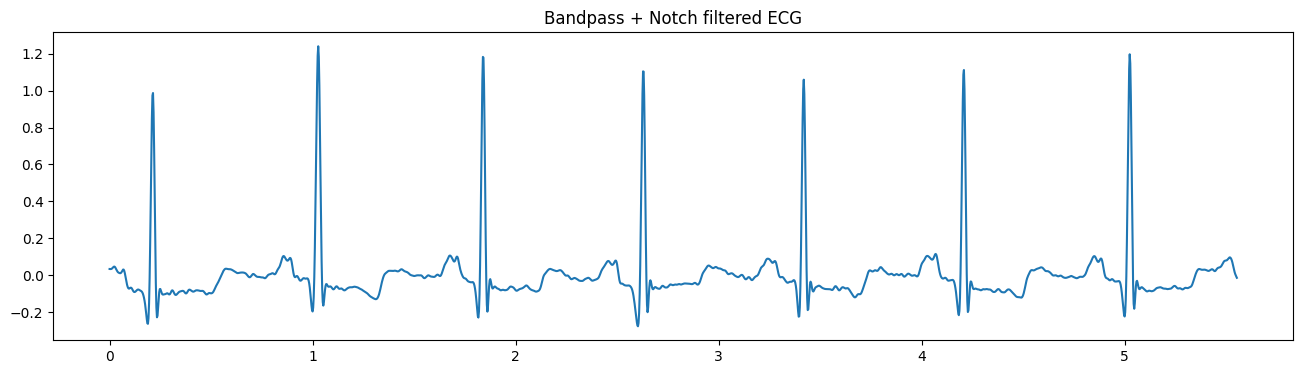

In [ ]:

from scipy.signal import iirnotch

def notch_filter(x, freq, fs, Q=30):
    w0 = freq / (fs/2)
    b, a = iirnotch(w0, Q)
    return filtfilt(b, a, x)

filtered = notch_filter(filtered, 50, fs)  # yoki 60
plt.figure(figsize=(16, 4))
plt.plot(t[:2000], filtered[:2000])
plt.title('Bandpass + Notch filtered ECG')
plt.show()

#

#4. R-piklarni aniqlash (Pan-Tompkins uslubiga yaqin yondashuv)

Pan-Tompkins to‘liq algoritmi bir necha bosqichdan iborat. Quyida soddalashtirilgan, ammo samarali yondashuv (diff → square → moving average → peak detection):

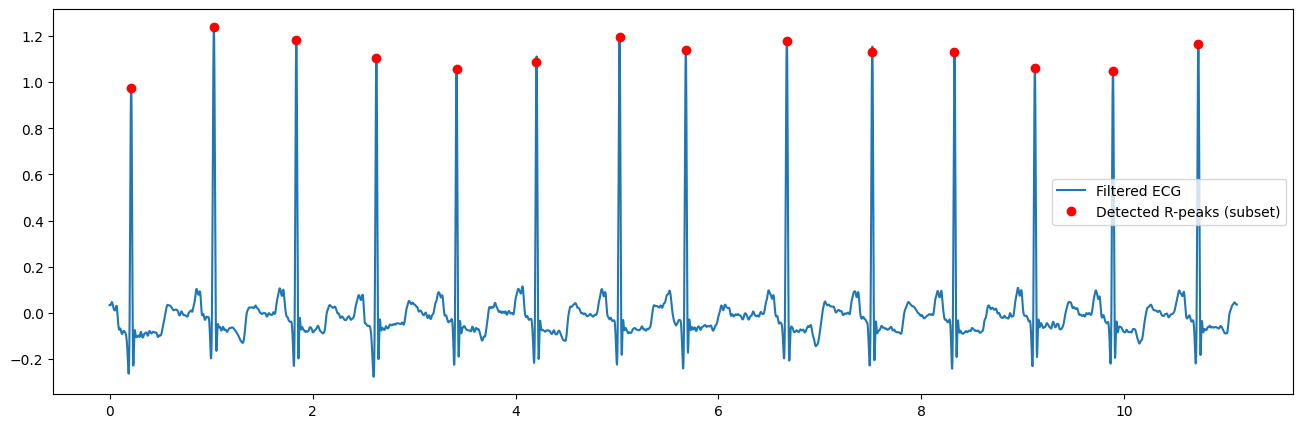

In [ ]:

from scipy.signal import find_peaks

# 1) Filtrlangan signalni olish (yuqorida)
ecg = filtered

# 2) Diferensial operator (tebranishni oshirish)
diff = np.ediff1d(ecg)
diff = np.append(diff, 0)

# 3) Kvadratlash
squared = diff**2

# 4) Integratsiya (moving window)
window_size = int(0.04 * fs)  # 150 ms
integrated = np.convolve(squared, np.ones(window_size)/window_size, mode='same')

# 5) Piklarni aniqlash
peaks, props = find_peaks(integrated, distance=int(0.2*fs), height=np.mean(integrated))
r_peaks_times = peaks / fs

# Vizualizatsiya
plt.figure(figsize=(16, 5))
plt.plot(t[:4000], ecg[:4000], label='Filtered ECG')
plt.plot(peaks[:14]/fs, ecg[peaks[:14]], 'ro', label='Detected R-peaks (subset)')
plt.legend()
plt.show()


#5. Xususiyatlarni (features) ajratish
##5.1 RR-interval va HR (yurak tezligi)

In [ ]:
r_indices = peaks  # indekslar
rr_intervals = np.diff(r_indices) / fs  # sekundlarda
hr = 60 / rr_intervals  # BPM (beats per minute)

import numpy as np
print("Mean RR (s):", np.mean(rr_intervals))
print("Mean HR (BPM):", np.mean(hr))



Mean RR (s): 0.7942464682015936
Mean HR (BPM): 75.87516008175355


##5.2 HRV (time-domain) — asosiy ko‘rsatkichlar

In [ ]:

def hrv_time_domain(rr_intervals):
    rr_ms = rr_intervals * 1000  # ms
    mean_rr = np.mean(rr_ms)
    sdnn = np.std(rr_ms, ddof=1)
    diff_rr = np.diff(rr_ms)
    rmssd = np.sqrt(np.mean(diff_rr**2))
    pnn50 = np.sum(np.abs(diff_rr) > 50) / len(diff_rr) * 100
    return {'mean_rr_ms': mean_rr, 'sdnn_ms': sdnn, 'rmssd_ms': rmssd, 'pnn50': pnn50}

print(hrv_time_domain(rr_intervals))


{'mean_rr_ms': np.float64(794.2464682015935), 'sdnn_ms': np.float64(49.4181297547639), 'rmssd_ms': np.float64(62.80185431815681), 'pnn50': np.float64(9.727112676056338)}


##5.3 Frequency-domain HRV (Welch PSD)

In [ ]:

from scipy.signal import welch

# RR series interpolation is usually needed. Here simple approach:
f, Pxx = welch(rr_intervals - np.mean(rr_intervals), fs=4.0, nperseg=256)
# but better: resample RR as evenly spaced series (interpolate), then welch




#5.4 `QRS` va boshqa morfologik xususiyatlar

`QRS` duration (sekundlarda)

`PR` interval, `QT` interval (agar annotatsiyalar mavjud bo‘lsa)

`R-pik` amplitudasi, `T`-to‘lqin xususiyatlari

(Morfologik xususiyatlar uchun R-pik pozitsiyasidan oldingi/postdagi oynalarni kesib, statistik va spektral xususiyatlar hisoblanadi.)

In [ ]:
# 1️⃣ Kutubxonalarni chaqirish
import wfdb
import neurokit2 as nk
import matplotlib.pyplot as plt
import numpy as np

# 2️⃣ MIT-BIH yozuvini o‘qish (masalan: 100)
record = wfdb.rdrecord("100", pn_dir='mitdb')
signal = record.p_signal[:,0]
fs = record.fs  # diskretizatsiya chastotasi

# 3️⃣ QRS cho‘qqilari va boshqa to‘lqinlarni aniqlash
signals, info = nk.ecg_process(signal, sampling_rate=fs)

# R cho‘qqilari
rpeaks = info["ECG_R_Peaks"]

# PR, QRS, QT, ST ni chiqarish uchun NK2 signal belgilaridan foydalanamiz
# Note: Some delineation methods may not return all waves or might return NaNs.
# We will handle potential NaNs when plotting.
try:
    waves = nk.ecg_delineate(signal, rpeaks, sampling_rate=fs, method="dwt")
    q_onsets = waves[1].get("ECG_Q_Onsets", []) # Use .get to handle potential missing keys
    q_offsets = waves[1].get("ECG_S_Offsets", [])
    p_onsets = waves[1].get("ECG_P_Onsets", [])
    t_offsets = waves[1].get("ECG_T_Offsets", [])
except Exception as e:
    print(f"Could not delineate waves: {e}")
    q_onsets, q_offsets, p_onsets, t_offsets = [], [], [], []


# 4️⃣ Intervallarni hisoblash (only for non-NaN rpeaks)
valid_rpeaks = rpeaks[~np.isnan(rpeaks)].astype(int)
rr_intervals = np.diff(valid_rpeaks) / fs * 1000


# 5️⃣ Vizualizatsiya
plt.figure(figsize=(15, 5))
plt.plot(signal[:2000], label="ECG signal")

# R cho‘qqilar (only plot valid rpeaks within the visible range)
visible_rpeaks = valid_rpeaks[valid_rpeaks < 2000]
plt.plot(visible_rpeaks, signal[visible_rpeaks], "ro", label="R peaks (subset)")


# QRS segmentlari (only plot valid and visible segments)
for q, s in zip(q_onsets, q_offsets):
    if q is not None and s is not None and not np.isnan(q) and not np.isnan(s):
        q_int, s_int = int(q), int(s)
        if s_int < 2000:
            plt.axvspan(q_int, s_int, color="yellow", alpha=0.3, label="QRS" if q == q_onsets[0] else "")

# P to‘lqinlari (only plot valid and visible onsets)
for p in p_onsets:
    if p is not None and not np.isnan(p):
        p_int = int(p)
        if p_int < 2000:
            plt.axvline(p_int, color="green", linestyle="--", label="P onset" if p == p_onsets[0] else "")

# T to‘lqinlari (only plot valid and visible offsets)
for t in t_offsets:
    if t is not None and not np.isnan(t):
        t_int = int(t)
        if t_int < 2000:
            plt.axvline(t_int, color="purple", linestyle="--", label="T offset" if t == t_offsets[0] else "")

plt.legend()
plt.title("EKG signalining morfologik xususiyatlari")
plt.xlabel("Vaqt (nampla)")
plt.ylabel("Amplituda (mV)")
plt.show()

# 6️⃣ Natijalarni chiqarish (only for non-NaN rr_intervals)
valid_rr_intervals = rr_intervals[~np.isnan(rr_intervals)]
print("RR interval (ms):", valid_rr_intervals[:10])

ModuleNotFoundError: No module named 'wfdb'

#6. Ma’lumotlarni belgilash (labels) — MIT-BIH annotatsiyalari

MIT-BIH yozuvlari bilan birga annotatsiyalar (beat annotation) ham bor. `wfdb.rdann` yordamida ularni o‘qib, har bir R-pikni tegishli sinfga moslashtirish mumkin (N-normal, V-ventricular ectopic va boshqalar).

In [ ]:
ann = wfdb.rdann('100', 'atr', pn_dir='mitdb')
print(len(ann.sample), ann.symbol[:20])
# ann.sample — R-pik indekslari (namuna soni)
# ann.symbol — beat turlari


2274 ['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']


#7. Tasniflash (Machine Learning)

Quyida xususiyatlar vektorini tayyorlab, sodda Random Forest bilan klassifikatsiya namunasini ko‘ramiz.

##7.1 Xususiyatlar jadvali yaratish

Har bir yuborilgan heartbeat (masalan, R-pikga o‘ralgan 250 ms oynada) uchun: mean amplitude, max amplitude, QRS duration, RR_prev, RR_next, HRV parametrlar (agar kontekst kerak bo‘lsa) — bu sizning `X`.

Annotatsiyalar bo‘yicha markerlardan `y` (label) hosil qilinadi (normal vs pathological yoki ko‘plab sinflar).

##7.2 Sklearn bilan model qurish

In [ ]:
# Assuming 'filtered' is the filtered ECG signal, 'peaks' are the detected R-peak indices, and 'ann' are the annotations.
# We will create simple features for demonstration purposes. More advanced features can be added.

X = []
y = []
window_size_samples = int(0.25 * fs) # e.g., 250 ms window around R-peak

# Create a mapping from annotation symbols to labels
# This is a simplified mapping. You might need a more detailed one based on your task.
# N, L, R, e, j are typically considered 'Normal' or supraventricular
# V, E are typically considered 'Ventricular'
# F is Fusion, A is Atrial Premature, S is Supraventricular Premature
# Q is Unknown/Artifact

normal_beats = ['N', 'L', 'R', 'e', 'j']
pathological_beats = ['V', 'E', 'A', 'S', 'F', 'Q'] # Simplified; adjust as needed

# Align R-peaks with annotations
# Find the closest annotation for each detected R-peak
annotated_peak_indices = ann.sample
annotated_symbols = ann.symbol

# This is a basic approach. More robust alignment might be needed for real applications.
aligned_labels = []
aligned_features = []
aligned_r_peaks_indices = []

# Iterate through the detected R-peaks
for peak_idx in peaks:
    # Find the closest annotation to this R-peak
    closest_ann_idx = np.argmin(np.abs(annotated_peak_indices - peak_idx))
    closest_annotation_sample = annotated_peak_indices[closest_ann_idx]
    closest_annotation_symbol = annotated_symbols[closest_ann_idx]

    # Optional: Add a check to ensure the peak is reasonably close to the annotation
    if np.abs(peak_idx - closest_annotation_sample) < int(0.05 * fs): # e.g., within 50ms
        # Extract features around the R-peak
        start_idx = max(0, peak_idx - window_size_samples // 2)
        end_idx = min(len(filtered), peak_idx + window_size_samples // 2)
        beat_segment = filtered[start_idx:end_idx]

        # Simple features: mean, max, min, std of the segment
        if len(beat_segment) > 0:
            features = [
                np.mean(beat_segment),
                np.max(beat_segment),
                np.min(beat_segment),
                np.std(beat_segment)
                # Add more features here (e.g., QRS duration estimate, RR interval)
            ]
            aligned_features.append(features)
            aligned_r_peaks_indices.append(peak_idx)

            # Assign label based on the annotation symbol
            if closest_annotation_symbol in normal_beats:
                aligned_labels.append(0) # 0 for Normal
            elif closest_annotation_symbol in pathological_beats:
                 aligned_labels.append(1) # 1 for Pathological (simplified binary classification)
            else:
                aligned_labels.append(-1) # Ignore unclassified beats

# Convert to numpy arrays and filter out unclassified beats
X = np.array(aligned_features)
y = np.array(aligned_labels)

# Filter out beats with label -1
valid_indices = y != -1
X = X[valid_indices]
y = y[valid_indices]
aligned_r_peaks_indices = np.array(aligned_r_peaks_indices)[valid_indices]


print("Shape of X (features):", X.shape)
print("Shape of y (labels):", y.shape)
print("Example labels:", y[:20])

Shape of X (features): (2273, 4)
Shape of y (labels): (2273,)
Example labels: [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# X — features (numpy array), y — labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       448
           1       0.00      0.00      0.00         7

    accuracy                           0.98       455
   macro avg       0.49      0.50      0.50       455
weighted avg       0.97      0.98      0.98       455

[[448   0]
 [  7   0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#8. Chuqur o‘rganish (1D-CNN) — to‘g‘ridan-to‘g‘ri signal bo‘yicha
##8.1 Segmentlar yaratish

Har bir R-pik atrofidan (masalan, −200 ms .. +400 ms) segment kesib olinadi.

Segmentlar bir xil uzunlikka (masalan, 600 sample) keltiriladi va X_segments massivi hosil qilinadi.

##8.2 Keras (TensorFlow) modeli misoli

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = (600, 1)  # misol

# Define the number of classes based on your problem (e.g., 2 for binary classification)
num_classes = 2

model = models.Sequential([
    layers.Conv1D(32, kernel_size=7, activation='relu', input_shape=input_shape),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, kernel_size=5, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Fit
# model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=64)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 594, 32)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 297, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 293, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 146, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 144, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,650 (170.51 KB)

 Trainable params: 43,650 (170.51 KB)

 Non-trainable params: 0 (0.00 B)

#9. Baholash (evaluation)

Classification report: precision, recall, f1-score — har bir sinf uchun.

Confusion matrix — noto‘g‘ri sinflanishlarni tahlil qilish.

ROC-AUC (binarlashgan vaziyatda) — sinov sifatini baholash.

Cross-validation (k-fold) — modelning umumiylashuv qobiliyatini baholash.

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X, y, cv=5, scoring='f1_macro')
print("Cross-validated F1:", scores.mean())


Cross-validated F1: 0.49623231559518394


#10. Vizualizatsiya va hisobot

Original va filtrlangan EKG grafigi, aniqlangan R-piklar.

RR-intervallar grafigi va histogrammasi.

Confusion matrix iliq ranglarda.

ROC curve.

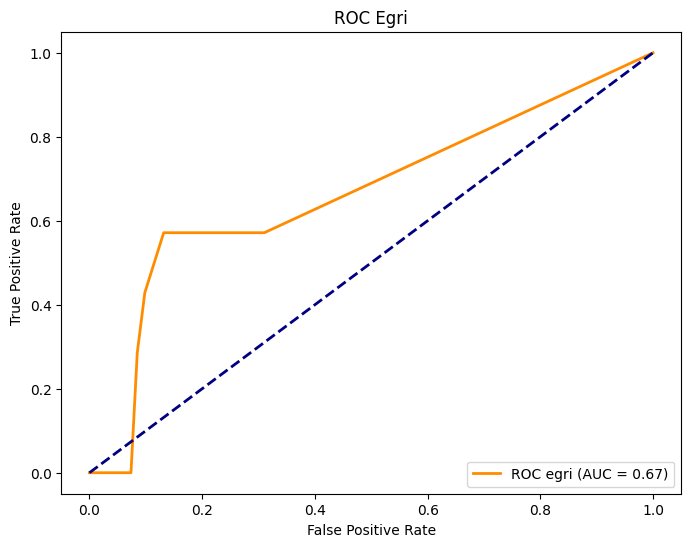

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# y_test = asl label (0 yoki 1)
# y_score = modeldan chiqqan ehtimollik (predict_proba[:,1])
y_score = clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC egri (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Egri')
plt.legend(loc="lower right")
plt.show()

#11. Tavsiya etiladigan tajribalar (eksperimenti variantlari)

Pan-Tompkins (klassik) vs soddalashtirilgan peak detection — aniqlik va false-positive darajalarini solishtirish.

Xususiyat-asoslangan ML (RandomForest, SVM) vs raw-signal CNN — qaysi yondashuv yaxshiroq?

Sinflararo balansni tuzatish (oversampling / undersampling) ning natijaga taʼsiri.

Transfer learning: oldindan o‘qitilgan ECG-modellardan foydalanish (agar mavjud bo‘lsa).

Multi-lead vs single-lead (birkanalli) natijalarni taqqoslash.

#12. Etika va maxfiylik

Bemor ma’lumotlarining anonimlashtirilishi.

Tibbiy diagnostika tizimlarini ishlab chiqishda ehtiyotkorlik: model faqat yordamchi vosita bo‘lishi kerak, klinik qarorlarni shifokor qabul qiladi.

Ma’lumotlarni tarqatishda PhysioNet litsenziya shartlariga rioya qilish.

#13. Qo‘shimcha — amaliy maslahatlar

Pan-Tompkins uchun parametrlar (moving window uzunligi, threshold) yozuvlarga mos ravishda tune qilinadi.

Sampling chastotasi (360 Hz bo‘lsa yaxshi), lekin 250 Hz ham ko‘p hollarda yetarli.

Annotatsiyalarga ishonch, ammo annotatsiyalar ham xatolarga ega bo‘lishi mumkin — manual vizual tekshiruv zarur.

Katta yozuvlar bilan ishlaganda (butun diskdagi fayllar) streaming / batch processing yondashuvini qo‘llang (Spark yoki Dask).

#14. Ilova: muhim funksiyalar va parametrlar (tezkor jadval)

Filtr (bandpass): 0.5–40 Hz, order=4 (butterworth)

Notch: 50 yoki 60 Hz, Q=30

Moving window integratsiyasi: 100–200 ms

Minimal R-peak distance: 200 ms (0.2 s)

Segment oyna: −200 ms … +400 ms atrofida R-pik

#15. Foydalanilgan adabiyotlar va resurslar (boshlang‘ich ro‘yxat)

Moody G.B., Mark R.G. The MIT-BIH Arrhythmia Database (Computers in Cardiology, 1990).

Pan J., Tompkins W.J. A Real-Time QRS Detection Algorithm. IEEE Trans. on Biomedical Eng., 1985.

Rajpurkar P. et al. Cardiologist-level arrhythmia detection with deep neural networks. Nature Medicine, 2019.

WFDB Python Toolkit — https://wfdb.readthedocs.io

PhysioNet — https://physionet.org

#16. Yakuniy blok (talabalar uchun ko‘rsatma)

Loyihani GitHub’da yuriting, README bilan.

Kodni modularga bo‘ling: `data_loader.py`, `preprocessing.py`, `train_model.py`, `evaluate.py`.

Har bir qadam uchun Jupyter Notebook tuzing — grafikga asoslangan visual tekshiruvlar zarur.

Natijalarni jadval va grafik shaklida hisobotga joylashtiring; xulosalarda chegaralar va nosozliklarni ko‘rsating.